# Library

In [2]:
import utils
import pandas as pd
import model
import numpy as np
import requests
import io
import plotly.express as px
import matplotlib.pyplot as plt
import optuna
import datetime
import tensorflow as tf
%load_ext tensorboard

# Data

In [2]:
df = pd.read_csv('../gams_indoor.csv')

Choose to keep or not the data from the weekend (1 or 0)

In [3]:
df_t = utils.preprocessing(df=df, feature='co2', resample='5min', norm=1, weekend=0)

In [4]:
df_t.head()

ts
2016-11-21 00:45:00   -0.256114
2016-11-21 00:50:00   -0.273728
2016-11-21 00:55:00   -0.265073
2016-11-21 01:00:00   -0.259151
2016-11-21 01:05:00   -0.240018
Name: co2, dtype: float64

# Preprocessing

In [5]:
split = utils.train_test_split(df_t)
training_set = split[0]
testing_set = split[1]

In [6]:
training_data = utils.training_data(window=3, lookback=12, train=training_set)

In [7]:
testing_data = utils.testing_data(window=3, lookback=12, test=testing_set)

# Model optimization

Optuna uses TPE algorithm by default to search for hyperparameters. TPE requires many iterations to converge to an optimal solution, and it is recommended to run it for at least 200 iterations.

Source: https://docs.openvino.ai/2021.4/pot_compression_optimization_tpe_README.html

In [8]:
def objective(trial):
    default_opt = 'adam'
    lookback = trial.suggest_int('lookback', 3, 24)
    training_data = utils.training_data(window=3, lookback=lookback, train=training_set)
    
    forecaster = model.TS_predictor(lstm_cell = trial.suggest_int('lstm_cell', 50, 100),
                                          window = 3,
                                          lookback = lookback,
                                          optimizer = 'adam',
                                          loss = 'mean_absolute_percentage_error'
                                         )

    h = forecaster.train(epochs = 10,
                     batch_size = 32,
                     training_data = training_data
                    )
    
    return h.history['val_loss'][-1]



In [9]:
study = optuna.create_study(study_name='lstm_opt', direction='minimize')
study.optimize(objective, n_trials=2)

[I 2022-10-27 18:51:05,910] A new study created in memory with name: lstm_opt


Epoch 1/10
380/380 [==============================] - 5s 6ms/step - loss: 48.0216 - val_loss: 23.9921
Epoch 2/10
380/380 [==============================] - 2s 4ms/step - loss: 23.5875 - val_loss: 12.9367
Epoch 3/10
380/380 [==============================] - 2s 4ms/step - loss: 17.8788 - val_loss: 10.1874
Epoch 4/10
380/380 [==============================] - 2s 4ms/step - loss: 15.3917 - val_loss: 23.3029
Epoch 5/10
380/380 [==============================] - 2s 4ms/step - loss: 15.2037 - val_loss: 7.8841
Epoch 6/10
380/380 [==============================] - 2s 6ms/step - loss: 13.6127 - val_loss: 11.7007
Epoch 7/10
380/380 [==============================] - 2s 6ms/step - loss: 13.0529 - val_loss: 17.5726
Epoch 8/10
380/380 [==============================] - 2s 6ms/step - loss: 12.9891 - val_loss: 10.3653
Epoch 9/10
380/380 [==============================] - 2s 6ms/step - loss: 13.1699 - val_loss: 10.2198
Epoch 10/10
380/380 [==============================] - 2s 6ms/step - loss: 12.6109 

[I 2022-10-27 18:51:29,321] Trial 0 finished with value: 9.24562931060791 and parameters: {'lookback': 7, 'lstm_cell': 50}. Best is trial 0 with value: 9.24562931060791.


Epoch 1/10
380/380 [==============================] - 7s 12ms/step - loss: 45.9185 - val_loss: 13.6517
Epoch 2/10
380/380 [==============================] - 4s 10ms/step - loss: 23.5265 - val_loss: 11.3560
Epoch 3/10
380/380 [==============================] - 4s 10ms/step - loss: 17.9563 - val_loss: 8.6859
Epoch 4/10
380/380 [==============================] - 4s 9ms/step - loss: 14.9410 - val_loss: 9.6866
Epoch 5/10
380/380 [==============================] - 4s 10ms/step - loss: 14.4152 - val_loss: 9.3551
Epoch 6/10
380/380 [==============================] - 4s 11ms/step - loss: 14.1385 - val_loss: 7.5912
Epoch 7/10
380/380 [==============================] - 4s 10ms/step - loss: 13.3645 - val_loss: 10.2761
Epoch 8/10
380/380 [==============================] - 4s 10ms/step - loss: 12.9355 - val_loss: 9.6364
Epoch 9/10
380/380 [==============================] - 4s 10ms/step - loss: 12.8026 - val_loss: 7.4481
Epoch 10/10
380/380 [==============================] - 4s 11ms/step - loss: 12.4

[I 2022-10-27 18:52:11,277] Trial 1 finished with value: 6.973036289215088 and parameters: {'lookback': 10, 'lstm_cell': 95}. Best is trial 1 with value: 6.973036289215088.


In [10]:
study.best_trial.params

{'lookback': 10, 'lstm_cell': 95}

In [11]:
training_data = utils.training_data(window=3, lookback=study.best_trial.params['lookback'], train=training_set)
testing_data = utils.testing_data(window=3, lookback=study.best_trial.params['lookback'], test=testing_set)

forecaster = model.TS_predictor(lstm_cell = study.best_trial.params['lstm_cell'],
                                  window = 3,
                                  lookback = study.best_trial.params['lookback'],
                                  optimizer = 'adam',
                                  loss = 'mean_absolute_percentage_error'
                                 )

forecaster.train(epochs = 10,
                 batch_size = 32,
                 training_data = training_data
                )

Epoch 1/10
380/380 [==============================] - 7s 12ms/step - loss: 35.6829 - val_loss: 15.3042
Epoch 2/10
380/380 [==============================] - 4s 10ms/step - loss: 18.0320 - val_loss: 8.5566
Epoch 3/10
380/380 [==============================] - 4s 11ms/step - loss: 15.7912 - val_loss: 10.1457
Epoch 4/10
380/380 [==============================] - 4s 10ms/step - loss: 14.6265 - val_loss: 10.1528
Epoch 5/10
380/380 [==============================] - 4s 10ms/step - loss: 13.9049 - val_loss: 13.3243
Epoch 6/10
380/380 [==============================] - 4s 10ms/step - loss: 13.7560 - val_loss: 7.1084
Epoch 7/10
380/380 [==============================] - 4s 10ms/step - loss: 12.7327 - val_loss: 8.5920
Epoch 8/10
380/380 [==============================] - 4s 10ms/step - loss: 12.6110 - val_loss: 13.1647
Epoch 9/10
380/380 [==============================] - 4s 10ms/step - loss: 12.7694 - val_loss: 8.2261
Epoch 10/10
380/380 [==============================] - 4s 10ms/step - loss: 1

# Results

In [12]:
predicitons = forecaster.predict(testing_data)

232/232 [==============================] - 1s 3ms/step


In [29]:
df = pd.read_csv('demo.csv', index_col=[0])
df[['co2+1', 'co2+2', 'co2+3']]=predicitons[:]*s+m
df.to_csv('demo.csv')

## visualize

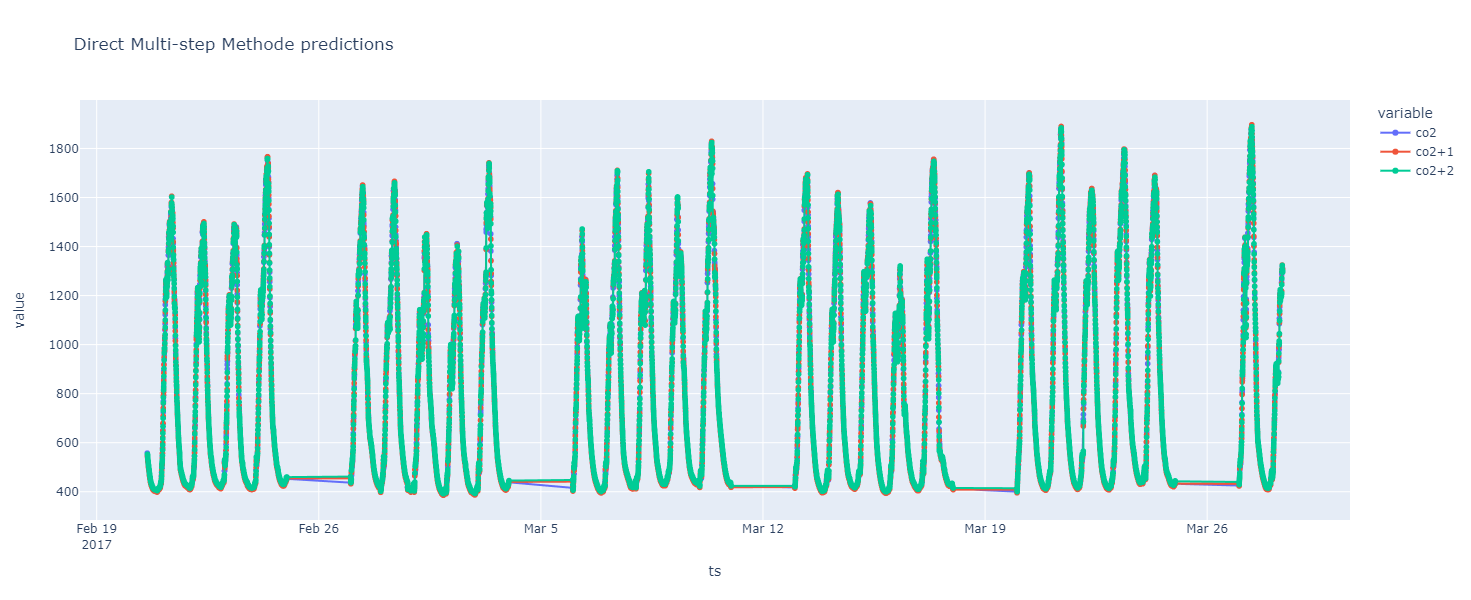

In [ ]:
fig = px.line(df[['co2', 'co2+1', 'co2+2']], title='Direct Multi-step Methode predictions', markers=True, width=1000, height=600)
fig.show()

In [12]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 4172), started 0:58:12 ago. (Use '!kill 4172' to kill it.)

# Send data to API

In [27]:
BASE_URL = "https://akeqm174e7.execute-api.ap-southeast-2.amazonaws.com/v1"

def get_csv_as_dataframe(layer:str, source_type: str, source_name: str, ts: str, table: str):
    get_url_endpoint = f"{BASE_URL}/{layer}/{source_type}/{source_name}/{ts}/{table}"
    url = requests.get(get_url_endpoint,
                      headers = {'x-api-key':'kLstD630gFavO1uiPyOuk7kLMNYV5siw14LBBVqI'}).json()['url']
    file_content = requests.get(url).content.decode()
    file_string = io.StringIO(file_content)
    return pd.read_csv(file_string)

def put_dataframe(df, layer: str, source_type: str, source_name: str, ts: str, table: str):
    put_url_endpoint = f"{BASE_URL}/{layer}/{source_type}/{source_name}/{ts}/{table}"
    url = requests.put(
        url = put_url_endpoint,
        headers = {'x-api-key':'kLstD630gFavO1uiPyOuk7kLMNYV5siw14LBBVqI'}
    ).json()['url']
    
    csv = df.to_csv(index=False)
    
    res = requests.put(
        url=url,
        data=csv,
        headers={'Content-Type': 'text/csv'}
    )
    return res.status_code

In [26]:
put_dataframe(df_t, 'bronze', 'web', 'gams', 'global', 'indoor_5m_pm10.csv')

200

In [29]:
get_csv_as_dataframe('bronze', 'web', 'gams', 'global', 'indoor_5m_pm10.csv')

,item_id,timestamp,target_value
0,1,2016-11-21 00:45:00,10.433333
1,1,2016-11-21 00:50:00,8.160000
2,1,2016-11-21 00:55:00,7.720000
3,1,2016-11-21 01:00:00,6.560000
4,1,2016-11-21 01:05:00,5.940000
...,...,...,...
24787,1,2017-03-28 09:10:00,6.120000
24788,1,2017-03-28 09:15:00,6.220000
24789,1,2017-03-28 09:20:00,5.880000
24790,1,2017-03-28 09:25:00,5.760000
